In [1]:
import torch
import torch.nn as nn
from Network import *

import pandas as pd

%matplotlib notebook
import matplotlib.pyplot as plt

In [8]:
class TFN(torch.nn.Module):
    def __init__(self, n_variables_past, n_variables_future, dim_model, n_quantiles = 3
                 , dropout_r = 0.1):
        super(TFN, self).__init__()
        self.vs_past = VSN(n_variables_past, dim_model, dropout_r = dropout_r)
        self.vs_future = VSN(n_variables_future, dim_model, dropout_r = dropout_r)
        
        self.enc = LSTMLayer(dim_model, dropout_r = dropout_r)
        self.dec = LSTMLayer(dim_model, dropout_r = dropout_r)
        
        self.gate1 = GLU(dim_model)
        self.norm1 = nn.LayerNorm(dim_model)
        
        self.static_enrich_grn= GRN(dim_model, dropout_r = dropout_r)
        
        self.dropout = nn.Dropout(dropout_r)
        
        self.fc_out = nn.Linear(dim_model, n_quantiles)
        
    #takes input (batch_size, past_seq_len, n_variables_past)
    #, (batch_size, future_seq_len, n_variables_future)
    def forward(self, x_past, x_future):
        #Encoder
        x_past = self.vs_past(x_past)
        
        e, e_hidden = self.enc(x_past)
        self.dec.hidden = e_hidden
        
        e = self.dropout(e)
        x_past = self.norm1(self.gate1(e) + x_past)
        
        #Decoder
        x_future = self.vs_future(x_future)
        
        d, _ = self.dec(x_future)
        d = self.dropout(d)
        x_future = self.norm1(self.gate1(d) + x_future)
        
        #Static enrichment (Without the static for now)
        x = torch.cat((x_past,x_future), dim = 1) #(batch_size, 2, dim_model)
        #x = static_enrich_grn(x)
        
        net_out = self.fc_out(x_future)
        return net_out
    
    def reset(self, batch_size):
        self.enc.reset(batch_size)
        self.dec.reset(batch_size)
        
batch_size = 1
n_variables_past = 1
n_variables_future = 1
past_seq_len = 10
future_seq_len = 10
dim_model = 10

quantiles = torch.tensor([0.1,0.5, 0.9]).float()

t = TFN(n_variables_past, n_variables_future, dim_model
        , n_quantiles = quantiles.shape[0], dropout_r = 0.2)
optimizer = torch.optim.Adam(t.parameters(), lr=0.01)

<IPython.core.display.Javascript object>


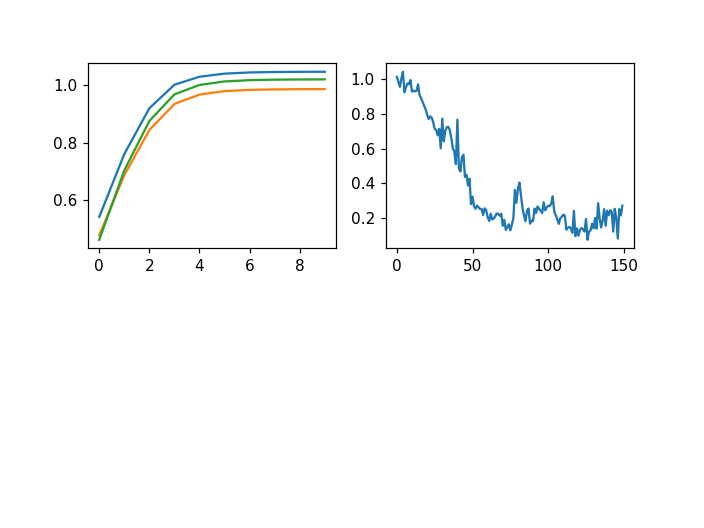

In [12]:
fig = plt.figure()
ax = fig.add_subplot(222)
ax1 = fig.add_subplot(221)
plt.ion()

fig.show()
fig.canvas.draw()
losses = []

for e in range(150):
    t.reset(batch_size)
    optimizer.zero_grad()
    
    #x_past = torch.zeros([batch_size, past_seq_len, n_variables_past])
    #x_future = torch.zeros([batch_size, future_seq_len, n_variables_future])
    #y = torch.rand([batch_size, future_seq_len, 1])
    x_past = torch.sigmoid(torch.arange(-past_seq_len, 0).float()).unsqueeze(0).unsqueeze(-1)
    x_future = torch.zeros([1, future_seq_len ,1])
    y = torch.sigmoid(torch.arange(0, future_seq_len).float()).unsqueeze(0).unsqueeze(-1)
    
    net_out = t(x_past, x_future)

    loss = torch.sum(QuantileLoss(net_out, y ,quantiles))
    losses.append(loss)
    loss.backward()
    optimizer.step()
    
    ax.clear()
    ax.plot(losses)
    
    ax1.clear()
    ax1.plot(net_out[0].squeeze().detach().numpy())
    
    fig.canvas.draw()
    

#print(torch.sum(torch.abs(net_out - y)))
#print(loss)
#print(net_out.shape)

In [ ]:
print()

<IPython.core.display.Javascript object>


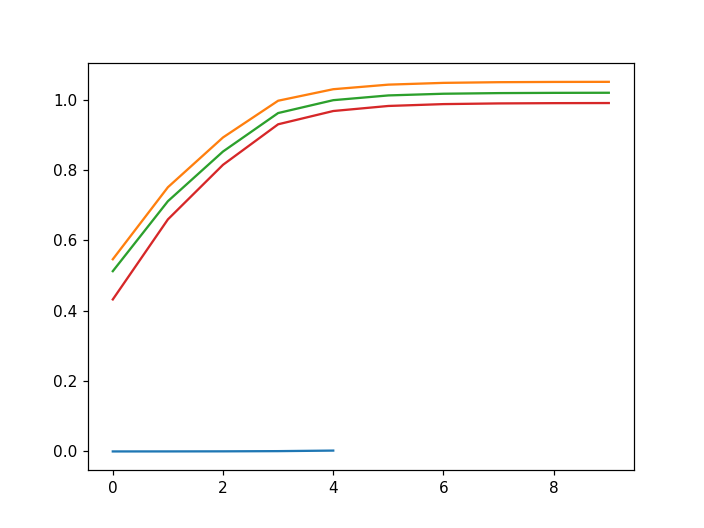

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

x_past = torch.sigmoid(torch.arange(-10,-5).float()).unsqueeze(0).unsqueeze(-1)
x_future = torch.zeros([1, 10 ,1])
y = torch.sigmoid(torch.arange(0, 10).float()).unsqueeze(0).unsqueeze(-1)

t.eval()
net_out = t(x_past, x_future)
ax.clear()

ax.plot(x_past.squeeze())
ax.plot(net_out[0].squeeze().detach().numpy())

In [ ]:
for i, idx in enumerate([6,4,87]):
    print(i)